In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL
from PIL import *
import seaborn as sns

In [2]:
facialexpression_df = pd.read_csv('./icml_face_data.csv')

In [3]:
facialexpression_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [4]:
# function to convert pixel values in string format to array format

def str2arr(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [5]:
# Resize images from (48 ,48) to (96, 96)
import cv2 

def resize(x):
    img = x.reshape(48, 48)
    return cv2.resize(img, dsize=(96,96),interpolation=cv2.INTER_CUBIC)

In [6]:
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: str2arr(x))

In [7]:
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: resize(x))

In [8]:
facialexpression_df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


In [9]:
class_labels = ['anger', 'disgust', 'sad', 'happiness', 'surprise']

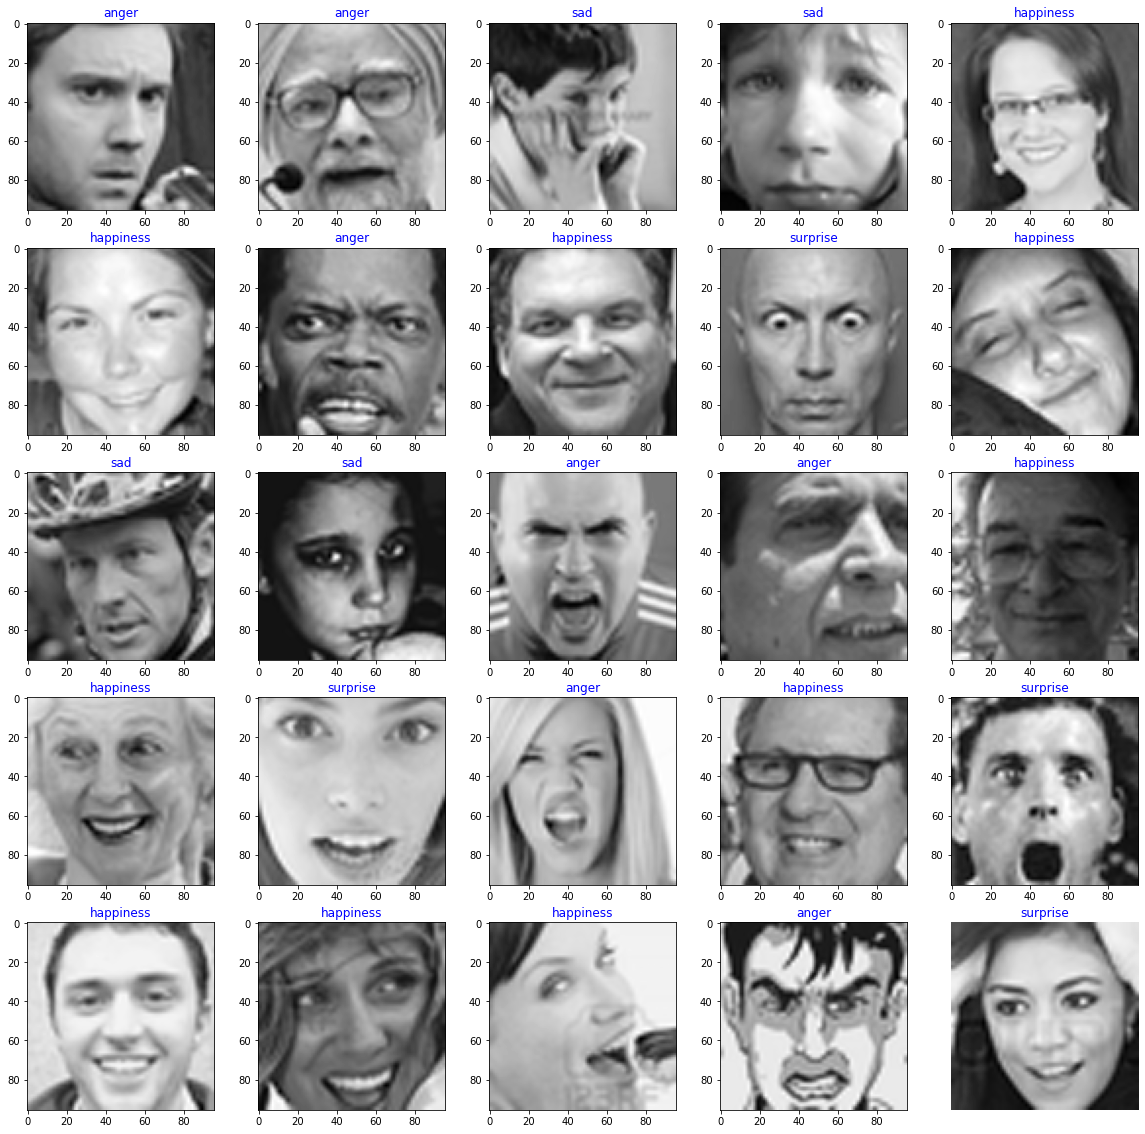

In [10]:
# Plot a grid of images
fig = plt.figure(figsize=(20,20))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    image = plt.imshow(facialexpression_df['pixels'][i], cmap="gray")
    plt.title(class_labels[facialexpression_df['emotion'][i]], c='b')
    
plt.axis('off')
plt.show()

['anger', 'disgust', 'sad', 'happiness', 'surprise']


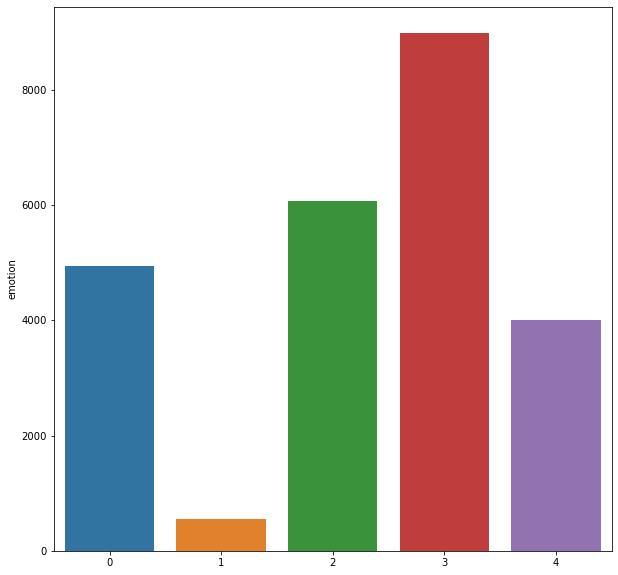

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())
print(class_labels)

In [52]:
from tensorflow.keras.utils import to_categorical

X = facialexpression_df['pixels']
y = to_categorical(facialexpression_df['emotion'])

In [53]:
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [54]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [55]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

In [58]:
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import *

def res_block(X, filters, stage):
    # Convolutional_block
    X_copy = X

    f1 , f2, f3 = filters

    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 
   
    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


    # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 1
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 2
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [59]:
input_shape = (96, 96, 1)
# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filters= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filters= [128,128,512], stage= 3)

# 4 - stage
X = res_block(X, filters= [256, 256, 1024], stage= 4)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name='Dense_final', kernel_initializer= glorot_uniform(seed = 0))(X)

model = Model( inputs= X_input, outputs = X, name='Resnet18')
#model.summary()

In [60]:
# train the network
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [61]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath = "./FacialExpression_checkpoint_balanced", verbose = 1, save_best_only=True)

In [62]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=64),
                              validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
                              epochs= 100, callbacks=[checkpointer, earlystopping])

Epoch 1/100
345/345 [==============================] - 28s 74ms/step - loss: 1.7827 - accuracy: 0.3602 - val_loss: 3.2931 - val_accuracy: 0.3257

Epoch 00001: val_loss improved from inf to 3.29312, saving model to ./FacialExpression_checkpoint_balanced
INFO:tensorflow:Assets written to: ./FacialExpression_checkpoint_balanced/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
345/345 [==============================] - 20s 59ms/step - loss: 1.3244 - accuracy: 0.4289 - val_loss: 1.4305 - val_accuracy: 0.3844

Epoch 00002: val_loss improved from 3.29312 to 1.43052, saving model to ./FacialExpression_checkpoint_balanced
INFO:tensorflow:Assets written to: ./FacialExpression_checkpoint_balanced/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/100
345/345 [==============================] - 20s 59ms/step - loss: 1.1820 - accuracy: 0.5019 - val_loss: 1.1980 - val_accuracy: 0.5537

Epoch 00003: val_loss improved from 1.43052 to 1.19797, saving model to ./FacialExpression_checkpoint_balanced
INFO:tensorflow:Assets written to: ./FacialExpression_checkpoint_balanced/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/100
345/345 [==============================] - 21s 60ms/step - loss: 1.0291 - accuracy: 0.5807 - val_loss: 1.1064 - val_accuracy: 0.5839

Epoch 00004: val_loss improved from 1.19797 to 1.10636, saving model to ./FacialExpression_checkpoint_balanced
INFO:tensorflow:Assets written to: ./FacialExpression_checkpoint_balanced/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/100
345/345 [==============================] - 20s 59ms/step - loss: 0.9379 - accuracy: 0.6274 - val_loss: 1.0405 - val_accuracy: 0.5611

Epoch 00005: val_loss improved from 1.10636 to 1.04046, saving model to ./FacialExpression_checkpoint_balanced
INFO:tensorflow:Assets written to: ./FacialExpression_checkpoint_balanced/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/100
345/345 [==============================] - 20s 58ms/step - loss: 0.8608 - accuracy: 0.6603 - val_loss: 1.4870 - val_accuracy: 0.3901

Epoch 00006: val_loss did not improve from 1.04046
Epoch 7/100
345/345 [==============================] - 21s 60ms/step - loss: 0.8117 - accuracy: 0.6817 - val_loss: 1.0491 - val_accuracy: 0.5594

Epoch 00007: val_loss did not improve from 1.04046
Epoch 8/100
345/345 [==============================] - 20s 58ms/step - loss: 0.7729 - accuracy: 0.6989 - val_loss: 1.1539 - val_accuracy: 0.5236

Epoch 00008: val_loss did not improve from 1.04046
Epoch 9/100
345/345 [==============================] - 21s 60ms/step - loss: 0.7408 - accuracy: 0.7161 - val_loss: 1.2640 - val_accuracy: 0.4935

Epoch 00009: val_loss did not improve from 1.04046
Epoch 10/100
345/345 [==============================] - 21s 60ms/step - loss: 0.7277 - accuracy: 0.7201 - val_loss: 0.7777 - val_accuracy: 0.6873

Epoch 00010: val_loss improved from 1.04046 to 0.77769, saving mo

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/100
345/345 [==============================] - 21s 60ms/step - loss: 0.7056 - accuracy: 0.7310 - val_loss: 1.1770 - val_accuracy: 0.6124

Epoch 00011: val_loss did not improve from 0.77769
Epoch 12/100
345/345 [==============================] - 21s 60ms/step - loss: 0.6870 - accuracy: 0.7355 - val_loss: 0.7155 - val_accuracy: 0.7231

Epoch 00012: val_loss improved from 0.77769 to 0.71553, saving model to ./FacialExpression_checkpoint_balanced
INFO:tensorflow:Assets written to: ./FacialExpression_checkpoint_balanced/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/100
345/345 [==============================] - 21s 60ms/step - loss: 0.6793 - accuracy: 0.7390 - val_loss: 0.8172 - val_accuracy: 0.6783

Epoch 00013: val_loss did not improve from 0.71553
Epoch 14/100
345/345 [==============================] - 20s 59ms/step - loss: 0.6659 - accuracy: 0.7452 - val_loss: 0.7390 - val_accuracy: 0.7142

Epoch 00014: val_loss did not improve from 0.71553
Epoch 15/100
345/345 [==============================] - 21s 59ms/step - loss: 0.6487 - accuracy: 0.7512 - val_loss: 0.6740 - val_accuracy: 0.7394

Epoch 00015: val_loss improved from 0.71553 to 0.67399, saving model to ./FacialExpression_checkpoint_balanced
INFO:tensorflow:Assets written to: ./FacialExpression_checkpoint_balanced/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/100
345/345 [==============================] - 20s 58ms/step - loss: 0.6400 - accuracy: 0.7557 - val_loss: 0.7250 - val_accuracy: 0.7207

Epoch 00016: val_loss did not improve from 0.67399
Epoch 17/100
345/345 [==============================] - 21s 59ms/step - loss: 0.6351 - accuracy: 0.7570 - val_loss: 0.7288 - val_accuracy: 0.7117

Epoch 00017: val_loss did not improve from 0.67399
Epoch 18/100
345/345 [==============================] - 21s 60ms/step - loss: 0.6193 - accuracy: 0.7605 - val_loss: 0.7429 - val_accuracy: 0.7117

Epoch 00018: val_loss did not improve from 0.67399
Epoch 19/100
345/345 [==============================] - 20s 59ms/step - loss: 0.6077 - accuracy: 0.7699 - val_loss: 0.6394 - val_accuracy: 0.7435

Epoch 00019: val_loss improved from 0.67399 to 0.63941, saving model to ./FacialExpression_checkpoint_balanced
INFO:tensorflow:Assets written to: ./FacialExpression_checkpoint_balanced/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/100
345/345 [==============================] - 20s 58ms/step - loss: 0.6058 - accuracy: 0.7723 - val_loss: 0.7953 - val_accuracy: 0.6873

Epoch 00020: val_loss did not improve from 0.63941
Epoch 21/100
345/345 [==============================] - 20s 58ms/step - loss: 0.5943 - accuracy: 0.7740 - val_loss: 1.2726 - val_accuracy: 0.5147

Epoch 00021: val_loss did not improve from 0.63941
Epoch 22/100
345/345 [==============================] - 21s 60ms/step - loss: 0.5842 - accuracy: 0.7777 - val_loss: 0.7455 - val_accuracy: 0.7044

Epoch 00022: val_loss did not improve from 0.63941
Epoch 23/100
345/345 [==============================] - 20s 59ms/step - loss: 0.5747 - accuracy: 0.7801 - val_loss: 0.7245 - val_accuracy: 0.7231

Epoch 00023: val_loss did not improve from 0.63941
Epoch 24/100
345/345 [==============================] - 20s 58ms/step - loss: 0.5702 - accuracy: 0.7808 - val_loss: 1.0558 - val_accuracy: 0.5676

Epoch 00024: val_loss did not improve from 0.63941
Epoch 25/1

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/100
345/345 [==============================] - 20s 58ms/step - loss: 0.5325 - accuracy: 0.7997 - val_loss: 0.7486 - val_accuracy: 0.6938

Epoch 00029: val_loss did not improve from 0.63219
Epoch 30/100
345/345 [==============================] - 20s 59ms/step - loss: 0.5214 - accuracy: 0.8021 - val_loss: 0.7010 - val_accuracy: 0.7248

Epoch 00030: val_loss did not improve from 0.63219
Epoch 31/100
345/345 [==============================] - 20s 58ms/step - loss: 0.5208 - accuracy: 0.8033 - val_loss: 0.8144 - val_accuracy: 0.6897

Epoch 00031: val_loss did not improve from 0.63219
Epoch 32/100
345/345 [==============================] - 20s 59ms/step - loss: 0.5049 - accuracy: 0.8121 - val_loss: 0.7518 - val_accuracy: 0.7134

Epoch 00032: val_loss did not improve from 0.63219
Epoch 33/100
345/345 [==============================] - 21s 60ms/step - loss: 0.5016 - accuracy: 0.8107 - val_loss: 1.2856 - val_accuracy: 0.5912

Epoch 00033: val_loss did not improve from 0.63219
Epoch 34/1

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 39/100
345/345 [==============================] - 20s 59ms/step - loss: 0.4721 - accuracy: 0.8225 - val_loss: 0.6876 - val_accuracy: 0.7484

Epoch 00039: val_loss did not improve from 0.61706
Epoch 40/100
345/345 [==============================] - 21s 59ms/step - loss: 0.4627 - accuracy: 0.8261 - val_loss: 0.6439 - val_accuracy: 0.7524

Epoch 00040: val_loss did not improve from 0.61706
Epoch 41/100
345/345 [==============================] - 21s 59ms/step - loss: 0.4557 - accuracy: 0.8285 - val_loss: 0.8640 - val_accuracy: 0.6954

Epoch 00041: val_loss did not improve from 0.61706
Epoch 42/100
345/345 [==============================] - 20s 58ms/step - loss: 0.4433 - accuracy: 0.8321 - val_loss: 0.6821 - val_accuracy: 0.7402

Epoch 00042: val_loss did not improve from 0.61706
Epoch 43/100
345/345 [==============================] - 21s 60ms/step - loss: 0.4470 - accuracy: 0.8328 - val_loss: 0.6004 - val_accuracy: 0.7801

Epoch 00043: val_loss improved from 0.61706 to 0.60042, savin

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/100
345/345 [==============================] - 20s 59ms/step - loss: 0.4370 - accuracy: 0.8362 - val_loss: 0.8780 - val_accuracy: 0.7068

Epoch 00044: val_loss did not improve from 0.60042
Epoch 45/100
345/345 [==============================] - 20s 59ms/step - loss: 0.4398 - accuracy: 0.8324 - val_loss: 0.9768 - val_accuracy: 0.6580

Epoch 00045: val_loss did not improve from 0.60042
Epoch 46/100
345/345 [==============================] - 20s 59ms/step - loss: 0.4299 - accuracy: 0.8364 - val_loss: 0.8113 - val_accuracy: 0.7182

Epoch 00046: val_loss did not improve from 0.60042
Epoch 47/100
345/345 [==============================] - 20s 59ms/step - loss: 0.4310 - accuracy: 0.8363 - val_loss: 0.8300 - val_accuracy: 0.7060

Epoch 00047: val_loss did not improve from 0.60042
Epoch 48/100
345/345 [==============================] - 20s 59ms/step - loss: 0.4254 - accuracy: 0.8385 - val_loss: 0.6363 - val_accuracy: 0.7638

Epoch 00048: val_loss did not improve from 0.60042
Epoch 49/1

In [64]:
# saving the model architecture to json file for future use

save_path = 'FacialExpression_model'
save_path = os.path.join('.', save_path)
model.save(save_path)

INFO:tensorflow:Assets written to: ./FacialExpression_model/assets


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [65]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

77/77 - 1s - loss: 0.6194 - accuracy: 0.7920
Restored model, accuracy: 79.20%


In [67]:
predicted_classes = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

<AxesSubplot:>

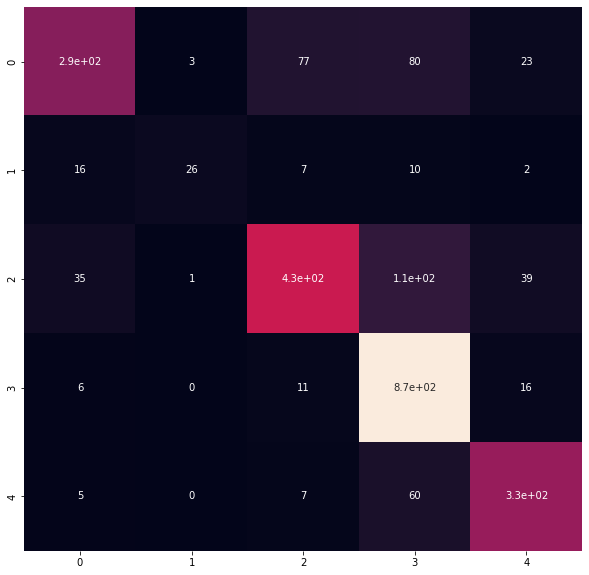

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

In [69]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy_score = accuracy_score(y_true,predicted_classes)
#recall = recall_score(y_true, predicted_classes) 
#precision = precision_score(y_true, predicted_classes)

In [70]:
accuracy_score

0.792022792022792

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71       477
           1       0.87      0.43      0.57        61
           2       0.81      0.70      0.75       619
           3       0.77      0.96      0.85       901
           4       0.80      0.82      0.81       399

    accuracy                           0.79      2457
   macro avg       0.81      0.70      0.74      2457
weighted avg       0.80      0.79      0.78      2457



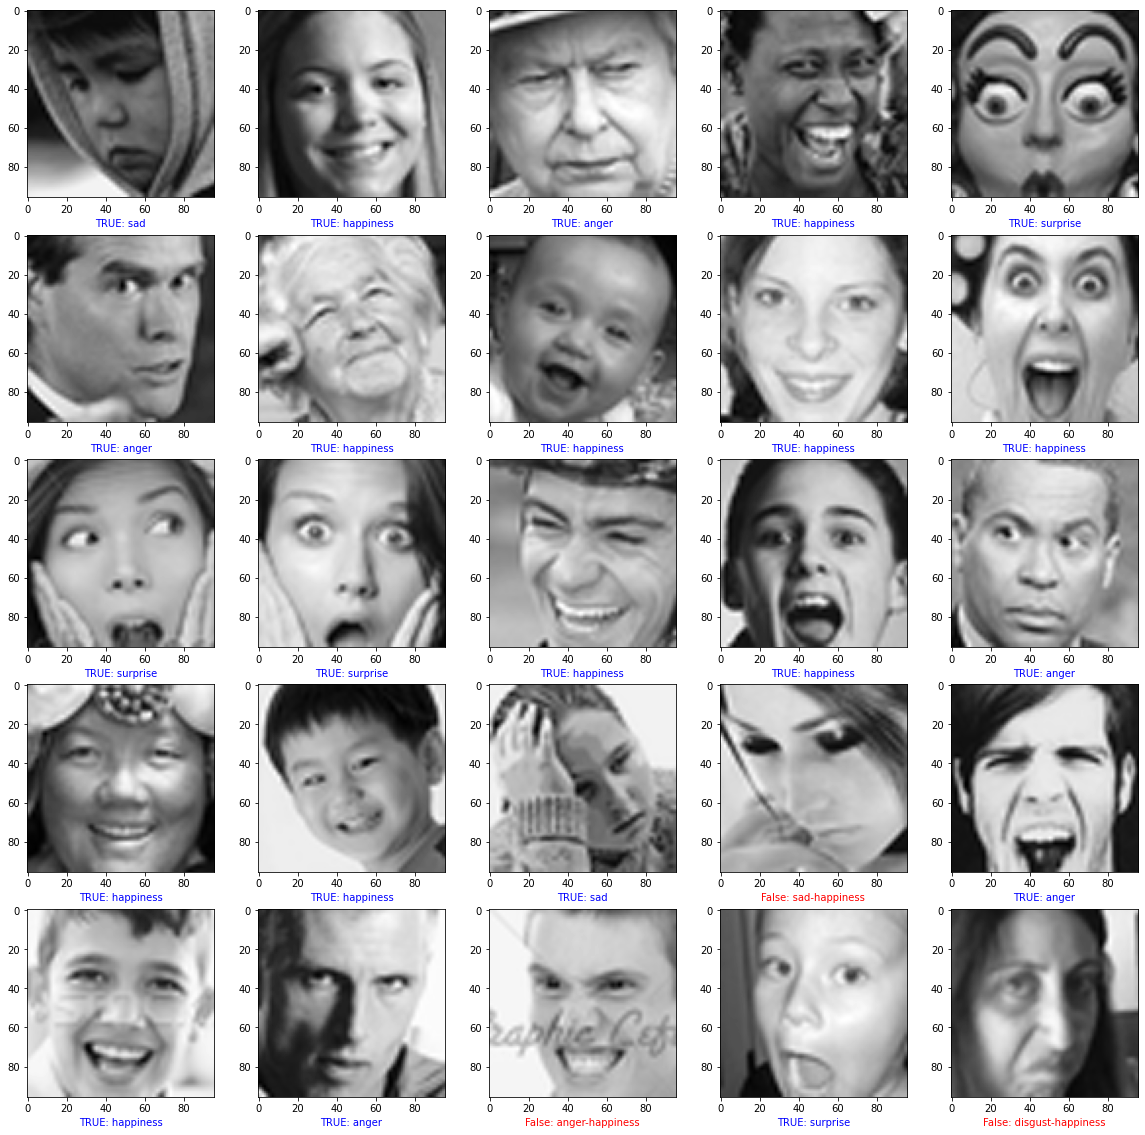

In [72]:
# Plot a grid of images
fig = plt.figure(figsize=(20,20))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    image = plt.imshow(X_test[i], cmap='gray')
    if y_true[i] == predicted_classes[i]: 
        plt.xlabel(f'TRUE: {class_labels[y_true[i]]}', c='b')
    else:
        plt.xlabel(f'False: {class_labels[y_true[i]]}-{class_labels[predicted_classes[i]]}', c='r')


In [73]:
def evaluateEachClass(y, yHat):
    anger_true = 0
    disgust_true = 0
    sad_true = 0
    happiness_true = 0
    surprise_true = 0
    
    count_arr = np.bincount(y_true)
    
    
    for index in range(len(y)):
        if y[index] == yHat[index]:
            if y[index] == 0:
                anger_true += 1
            elif y[index] == 1:
                disgust_true += 1
            elif y[index] == 2:
                sad_true += 1
            elif y[index] == 3:
                happiness_true += 1
            elif y[index] == 4:
                surprise_true += 1
                
    return anger_true*100/count_arr[0], disgust_true*100/count_arr[1], sad_true*100/count_arr[2], happiness_true*100/count_arr[3], surprise_true*100/count_arr[4]

In [74]:
angre_per, disgust_per, sad_per, happiness_per, surprise_per = evaluateEachClass(y_true, predicted_classes)

In [75]:
print("Anger: {:.2f}%".format(angre_per))
print("Disgust: {:.2f}%".format(disgust_per))
print("Sad: {:.2f}%".format(sad_per))
print("Happiness: {:.2f}%".format(happiness_per))
print("Surprise: {:.2f}%".format(surprise_per))

Anger: 61.64%
Disgust: 42.62%
Sad: 69.63%
Happiness: 96.34%
Surprise: 81.95%
